In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import seaborn.objects as so
from pandas.plotting import scatter_matrix
from pca import pca
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from sklearn import datasets
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Describing the project

A small European company producing garments from recycled materials (recycled rubbish) is working on a plan to market its products in other countries. The 10 largest trading partner countries of the European Union have been chosen as target markets. The economies of the selected countries differ from each other and the countries are not homogeneous. This necessitates an analysis of each individual country (macroeconomic indicators and forecasts, financial modelling, marketing and more). This is a long and expensive process, especially for the average fast growing company. The company is looking for a way to conduct the analysis in a shorter timeframe and lower budget. 

One option suggested was to analyse the currency volatility of the countries being considered for the partnership. Countries where the volatility of their own currencies is close to each other can be considered holistically rather than in isolation when building budget plans and financial models. 

Implementation of such a method can save the time and budget for the company. In addition, if the clustering analysis shows a positive result, it can also be extended to markets (currencies) in other countries by including their currency movements in the cluster analysis.

Exchange rate movements occur every day and often to a significant degree. By understanding the nature of currency movements in advance, the exporting company can reduce the risk of financial losses and save budget and time. The clustering of exchange rates of the countries of interest will be useful in making operational decisions. In this case:
* it will not be necessary to spend considerable time on primary analysis of each country whose currency shows dynamics;
* similar risk mitigation and hedging concepts can be developed for businesses in countries whose currency volatility is close to each other;
* it is faster and cheaper to simulate scenarios (negative, neutral, positive) for a group of countries whose currencies are in the same cluster than for each country individually.

This currency volatility clustering project is the primary, first step in the process of assessing groups of countries with similar currency volatility dynamics. Subsequently, it is possible to supplement the analysis with new variables in order to improve the quality of the clustering.

The scenario for the analysis in this project is as follows:
* perform primary data analysis
* perform PCA for reduction of dimensions
* perform HAC clustering
* perform EM-algorithm clustering
* optionally do DBSCAN clustering 


# Describing the data

The dataset for the analysis is a set of daily exchange rates of different currencies to the euro. The primary dataset includes 40 currencies and exchange rates for the period from 01.04.1999 to the present day. The data is updated and supplemented on a daily basis.

The data were obtained from the website of the European Central Bank. The data used is in .csv format, which is archived on the website (https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/index.en.html) as to 26.10.2022. Actual file could be downloaded as zip archive.

For the analysis in this project we will need to extract fragmentary information from the original dataset of interest:

* The period for analysis is from 01.03.2021 to 01.03.2022. This is the year (365 days) prior to Russia's military invasion of Ukraine. As this project is a pilot project, we consider that this period is objective and reasonable. In the future, it would be useful to consider further different timeframes: the early period (1999-2007), the crisis period (2007-2012), the recovery period (2012-2019) and the COVID pandemic crisis (2019-2021).

* for the project we are interested in a sample of countries from the list of countries available for analysis:
1) USD - United States
2) GBP - United Kingdom
3) CNY - China
4) CHF - Switzerland
5) RUB - Russia
6) TRY - Turkey
7) JPY - Japan
8) NOK - Norway
9) KRW - South Korea
10) CAD - Canada

After analysing the effectiveness of this project, further clustering analysis may include new currencies of interest

# Reading and cleaning data

* reading initial .csv file from the archive from the ECB website
* subsetting currences of the 10 main export partners of the EU
* seting index to the 'Date', as the observations
* sorting data in ascending order from 1st March 2021 to 1st March 2022
* checking missing data

In [10]:
data = pd.read_csv('data/eurofxref-hist.csv') #initial .csv file
data = data.get(['Date', 'USD', 'GBP', 'CNY', 'RUB', 'TRY', 'JPY', 'CHF', 'NOK', 'KRW', 'CAD']) #currences of the 10 main export partners of the EU
data = data.set_index('Date') # Dates should be observations, not variables
data = data['2022-03-01':'2021-03-01'] #choose the 1 year period before the war in the Ukraine
data.sort_index(ascending=True, inplace=True) #ascending order of the period (from 1st March 2021 to 1st March 2022)
print(data.isnull().sum().unique()) #checking missing data

[0]


There are no missing data in the dataset

The dataset for the project has 10 currences and 260 dates with exchange rates:

In [3]:
data

,USD,GBP,CNY,RUB,TRY,JPY,CHF,NOK,KRW,CAD
Date,,,,,,,,,,
2021-03-01,1.2053,0.86558,7.7970,89.3155,8.7175,128.63,1.1014,10.3600,1352.80,1.5274
2021-03-02,1.2028,0.86433,7.7840,88.6885,8.8151,128.58,1.1050,10.2555,1354.37,1.5225
2021-03-03,1.2048,0.86351,7.7897,88.8857,8.9009,128.81,1.1064,10.2451,1347.23,1.5234
2021-03-04,1.2034,0.86270,7.7846,88.6563,8.9666,129.23,1.1114,10.2595,1353.89,1.5213
2021-03-05,1.1938,0.86300,7.7489,88.8807,8.9502,129.30,1.1066,10.2110,1347.11,1.5160
...,...,...,...,...,...,...,...,...,...,...
2022-02-23,1.1344,0.83463,7.1669,90.8791,15.6871,130.58,1.0431,10.0335,1350.23,1.4394
2022-02-24,1.1163,0.83463,7.0601,95.7175,16.0525,128.28,1.0320,10.0878,1347.70,1.4316
2022-02-25,1.1216,0.83740,7.0828,92.5673,15.4799,129.64,1.0398,9.9756,1346.44,1.4325


We have 10 currences variables and 260 dates of observations

# Visualization of the data

To see what the data is look like we need to plot the exchange rates of different currences

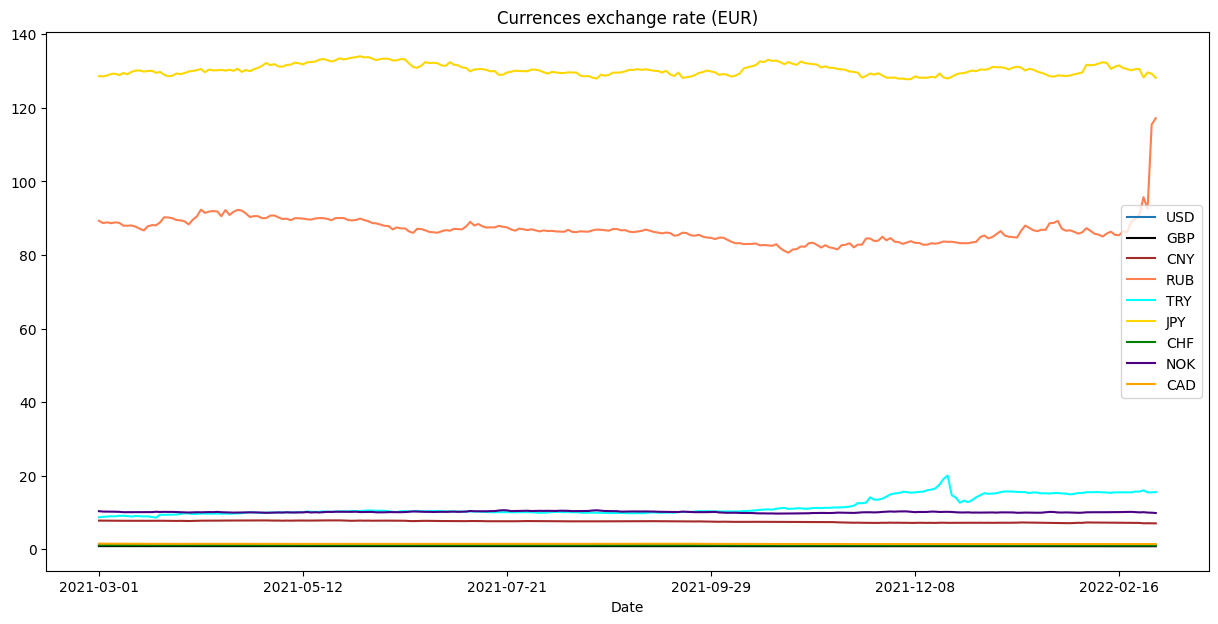

In [4]:
#Except KRW, the EUR/KRW rate is too big to fit the plot
data['USD'].plot(label = 'USD', figsize = (15,7))
data['GBP'].plot(label = "GBP", color= 'black')
data['CNY'].plot(label = 'CNY', color = 'brown')
data['RUB'].plot(label = 'RUB', color = 'coral')
data['TRY'].plot(label = 'TRY', color = 'cyan')
data['JPY'].plot(label = 'JPY', color = 'gold')
data['CHF'].plot(label = 'CHF', color = 'green')
data['NOK'].plot(label = 'NOK', color = 'indigo')
data['CAD'].plot(label = 'CAD', color = 'orange')
plt.title('Currences exchange rate (EUR)')
plt.legend()

It can be observed that the behaviour of different currencies differe. 

Some currencies rise more than others against the euro.

Also there is a problem wwith EUR/KRW pair - the ratio is too big to be plotted in the same figure with other currences. This problem we will solve later with scalling.

To see what the visualisation of exchange rates looks like in pairs we can further visualise the dataset. 

Let's look at the two-dimensional visualisation of cross-currency behaviour

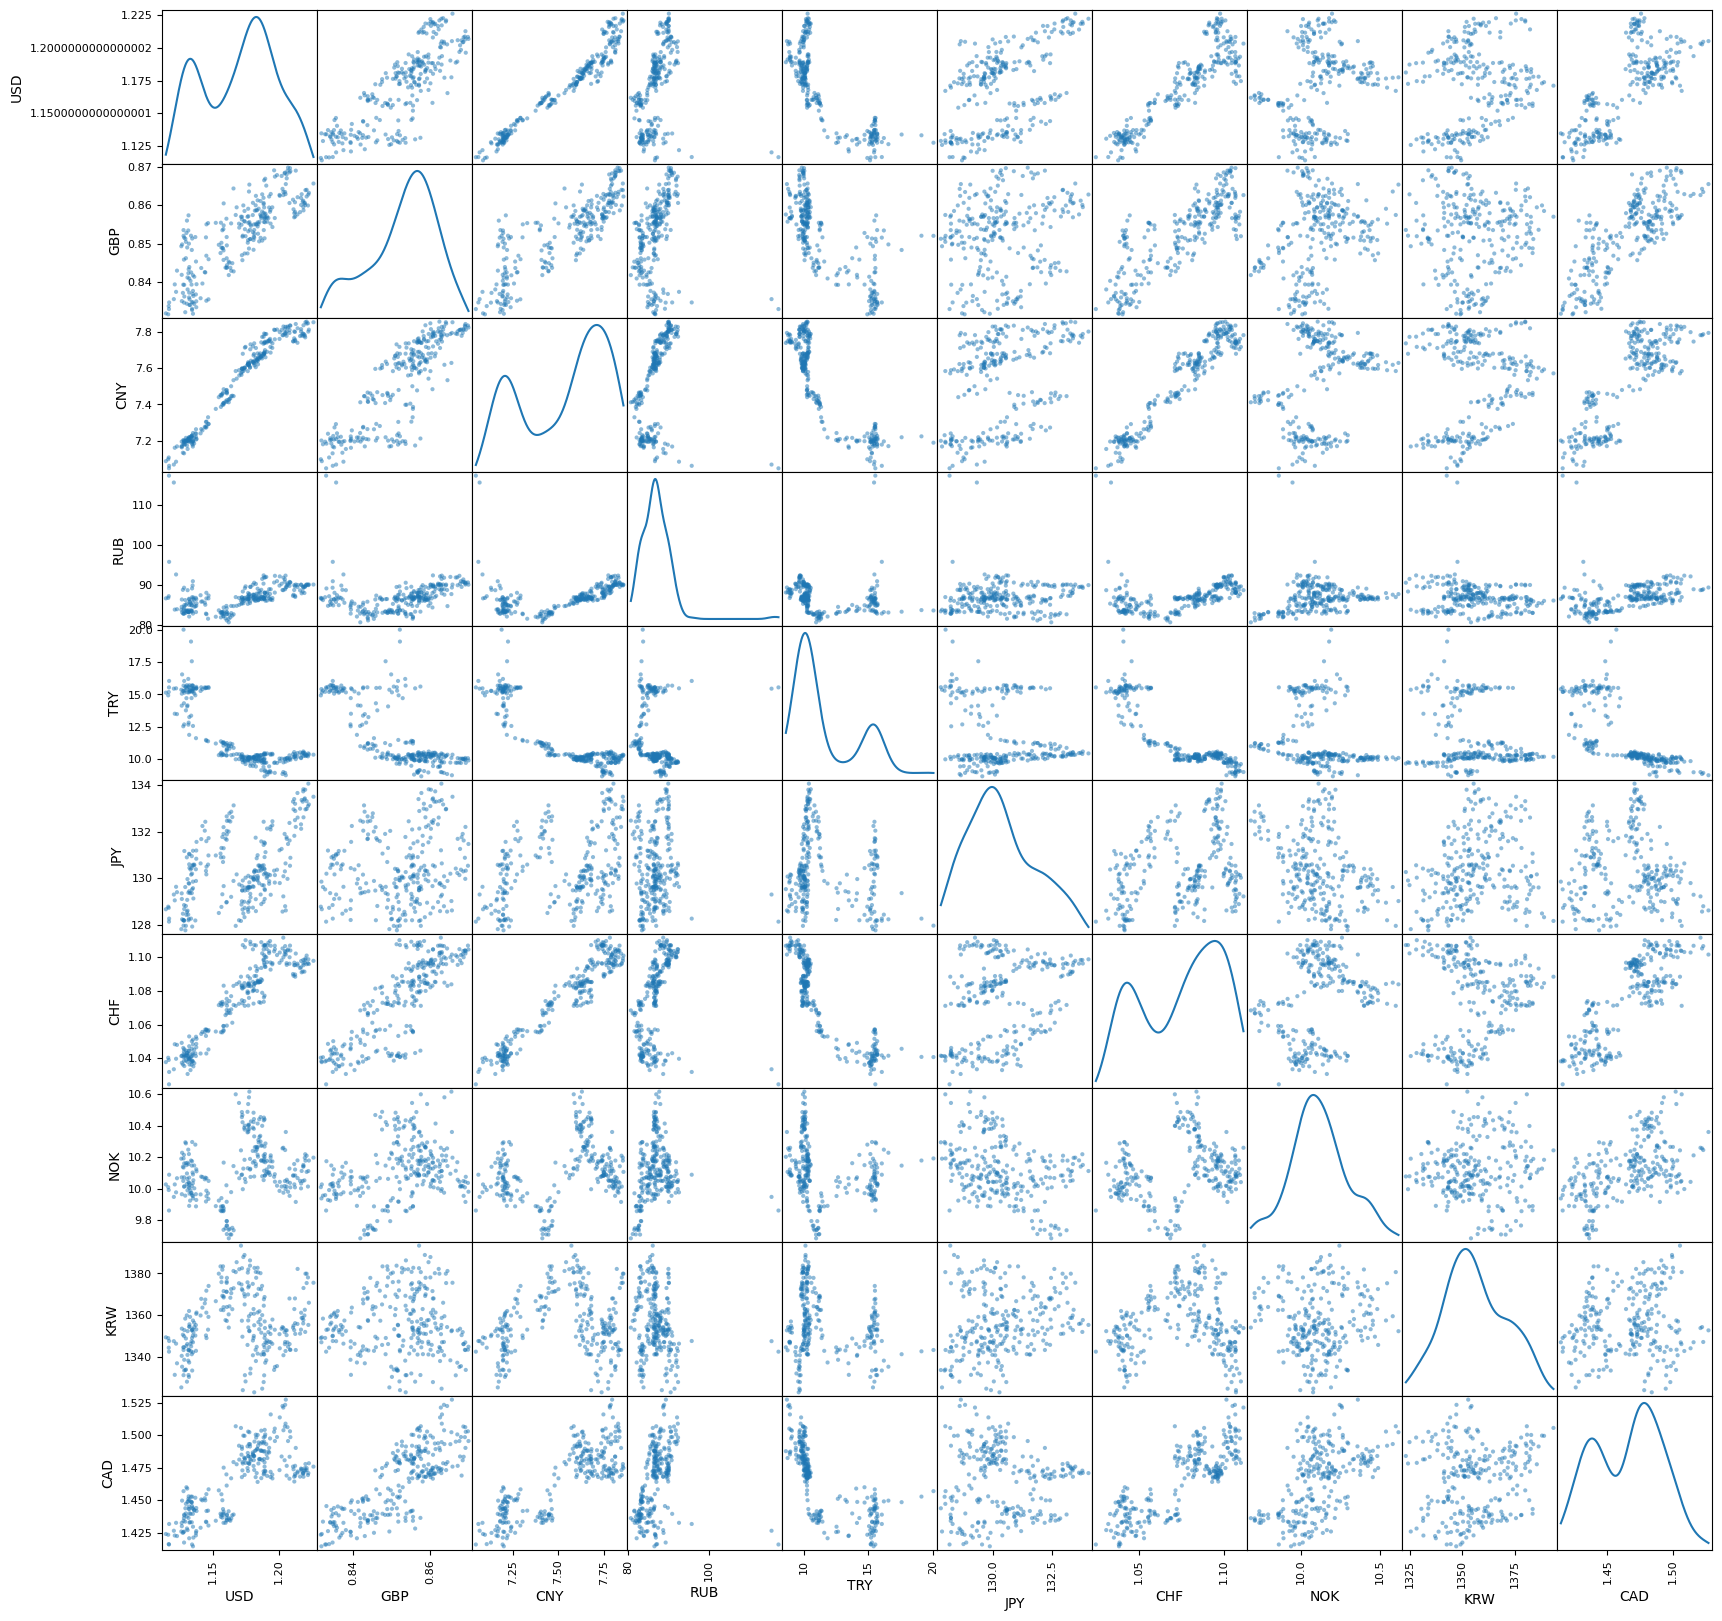

In [5]:
fig = scatter_matrix(data, figsize = (20,20), diagonal = 'kde') #plotting cross-rates

The graph shows that there is a definite linear relationship between some currencies (USD/GBP, USD/CNY, USD/CHF, CNY/CHF), some currencies do not have an explicit distributional dependency. This information, as well as the knowledge that the currency is an internationally traded asset, suggests that there is some correlation between the different currencies. This will come in handy in the future

We will continue our small project by standardising of the dataset to cover all 10 currencies and to exclude the influence of different scales

# Standartizing the data

In order to analyse the exchange rates of different countries, it is necessary to standardise the dataset, because currencies have different scales of exchange rates to the euro: 1 to 10, 1 to 100, 1 to 1000 and so on

In our case, standardisation is key because it looks at the degree of variation of the exchange rates of the currencies

In [7]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
data_sc = pd.DataFrame(data_sc, index = data.index, columns = data.columns).round(3)
data_sc

,USD,GBP,CNY,RUB,TRY,JPY,CHF,NOK,KRW,CAD
Date,,,,,,,,,,
2021-03-01,1.185,1.365,1.130,0.650,-1.180,-1.185,1.114,1.338,-0.230,2.378
2021-03-02,1.101,1.236,1.076,0.483,-1.140,-1.219,1.264,0.763,-0.124,2.189
2021-03-03,1.168,1.152,1.100,0.536,-1.104,-1.065,1.322,0.706,-0.607,2.224
2021-03-04,1.121,1.069,1.079,0.475,-1.077,-0.783,1.531,0.785,-0.156,2.143
2021-03-05,0.800,1.100,0.931,0.535,-1.084,-0.736,1.331,0.519,-0.615,1.939
...,...,...,...,...,...,...,...,...,...,...
2022-02-23,-1.187,-1.815,-1.482,1.067,1.703,0.122,-1.318,-0.457,-0.404,-1.009
2022-02-24,-1.792,-1.815,-1.925,2.357,1.854,-1.420,-1.781,-0.159,-0.575,-1.309
2022-02-25,-1.615,-1.530,-1.831,1.517,1.617,-0.508,-1.456,-0.775,-0.661,-1.275


Standardization involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one

Let's look at the visualisation of scaled dataset

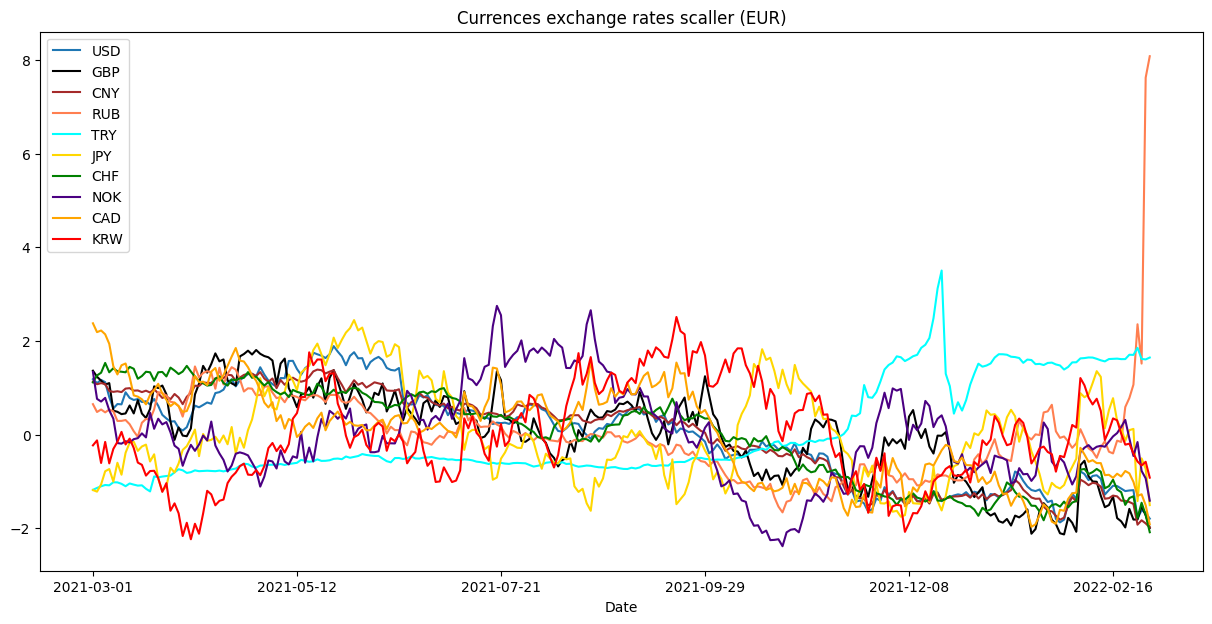

In [8]:
data_sc['USD'].plot(label = 'USD', figsize = (15,7))
data_sc['GBP'].plot(label = "GBP", color= 'black')
data_sc['CNY'].plot(label = 'CNY', color = 'brown')
data_sc['RUB'].plot(label = 'RUB', color = 'coral')
data_sc['TRY'].plot(label = 'TRY', color = 'cyan')
data_sc['JPY'].plot(label = 'JPY', color = 'gold')
data_sc['CHF'].plot(label = 'CHF', color = 'green')
data_sc['NOK'].plot(label = 'NOK', color = 'indigo')
data_sc['CAD'].plot(label = 'CAD', color = 'orange')
data_sc['KRW'].plot(label = 'KRW', color = 'red')
plt.title('Currences exchange rates scaller (EUR)')
plt.legend()

It is now much better to see exactly how the exchange rates of the different types of currencies are changing. In addition, all currencies of analysis can now be observed on the chart.

It is also clear from the graph that although the currencies behave differently, there is some confidence that it is possible to group them together with some way.

The next task is to find out if the exchange rates of different countries behave similarly to those of some other countries

# Principle Component Analysis (PCA)

At the moment we have 260 exchange rate observations. To start with, a PCA analysis should be carried out to identify the possibility of reducing them

We are dealing with different currences which exchange rates are correlated, so there is a smaller intrisic dimension

In [455]:
pca=PCA()
pca_transformed=pca.fit_transform(data_sc) #use scaled dataset
data_sc_pca=pd.DataFrame(pca_transformed, index=data_sc.index)
X_t=np.transpose(data_sc.to_numpy())#The same data but structured differently.
W = pca.components_
manually_computed_trafo=np.matmul(W, X_t)

Plotting the results of possible dimension reduction

PCA gives explanation variances: [0.554 0.156 0.116 0.075 0.05  0.025 0.013 0.006 0.004 0.001]


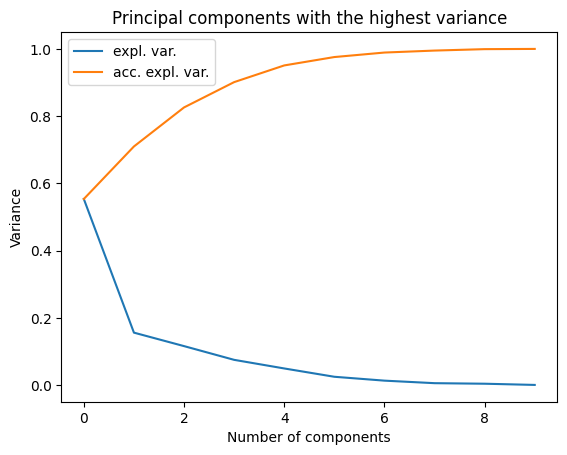

In [491]:
expl_var=pca.explained_variance_ratio_
print(f'PCA gives explanation variances: {expl_var.round(3)}')
plt.title('Principal components with the highest variance')
plt.xlabel('Number of components')
plt.ylabel('Variance')
plt.plot(expl_var, label='expl. var.')
plt.plot(np.add.accumulate(expl_var), label='acc. expl. var.')
plt.legend()

We can see that:
* PC1 gives 55.4% exploration of variance, PC2 - 15.6%, PC3 - 11.6%, PC4 - 7.5%
* The first 3 principal components account for over 82% of the variance
* The first 2 already for 66% of the variance

Now we can plot the data in a 2-D plot using only the first two components with the highest variance

We should note that after dimensionality reduction, there usually isn’t a particular meaning assigned to each principal component. The new components are just the two main dimensions of variation.

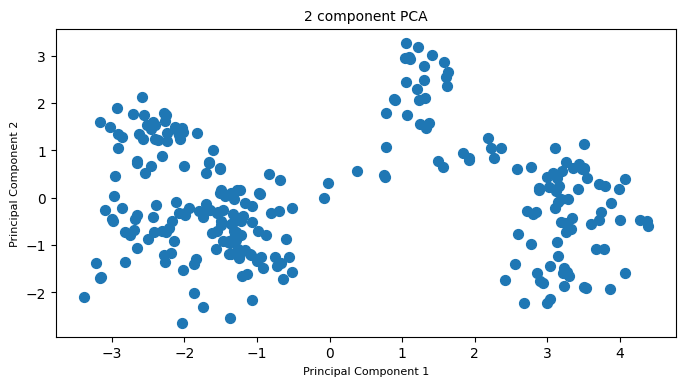

In [475]:
fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 8)
ax.set_ylabel('Principal Component 2', fontsize = 8)
ax.set_title('2 component PCA', fontsize = 10)
ax.scatter(data_sc_pca.iloc[:,0], data_sc_pca.iloc[:,1], s = 50)

From the plot we can observe that data can be grouped into 3 or 4 groups. In what follows we will use this number of clusters as a starting point for clustering

We can see how currencies themselves may look like with PCA

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [260] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


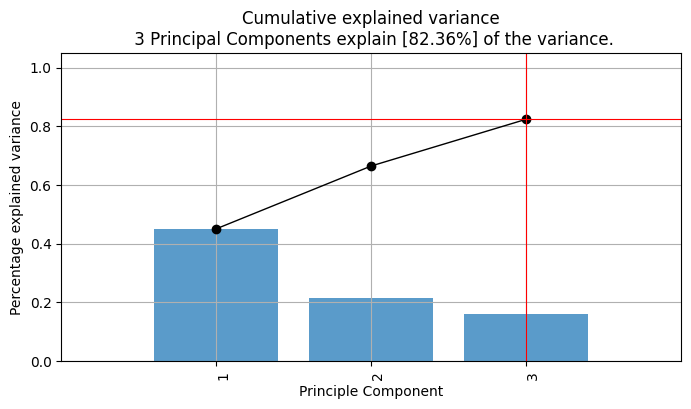

<Figure size 640x480 with 0 Axes>

In [503]:
from pca import pca
data_transposed = data_sc.transpose() #we transpose scaled data to check and look for currences
model = pca(n_components=3) #check 3 components
results = model.fit_transform(data_transposed)#fit transform
fig, ax = model.plot(figsize = (8,4))

We can see that 3 components explain 82% of the variance

Plotting the result with two main principle components

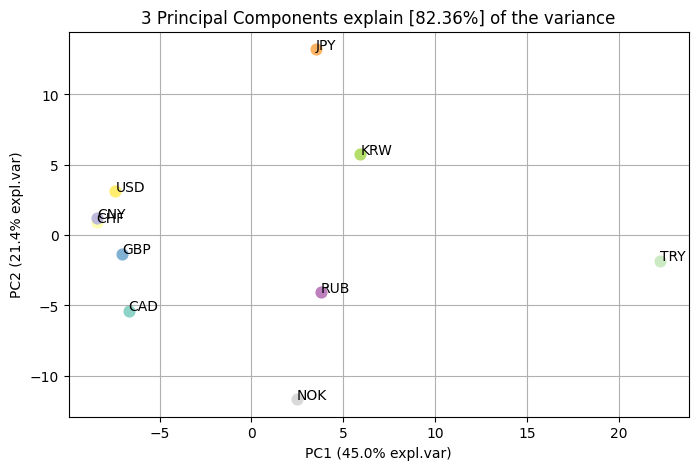

In [501]:
# Scatter first 2 PCs (1 and 2)
fig, ax = model.scatter(legend=False, PC=[0,1], label = True, figsize=(8,5), cmap='Set3')


We can see that exchange rates of different currences are grouped into 3 or 4 clusters.

For future clustering we will use principal components 1 and 2 from PCA as the the best explanation of variance of the currency exchange rates

In [510]:
model_results = model.results['PC'].reset_index(drop=True).get(['PC1','PC2'])
model_results

,PC1,PC2
0,-7.405693,3.113132
1,-7.024346,-1.308907
2,-8.394911,1.213144
3,3.788097,-4.039959
4,22.242962,-1.804435
5,3.489293,13.218079
6,-8.417221,0.906722
7,2.479669,-11.663514
8,5.923088,5.741031
9,-6.680937,-5.375294


In [516]:
model.results['explained_var'][[0,1]]

array([0.45009385, 0.66435045])

This two principal components will describe 66% of the variance in currencies exchange rates

The next step is using hierarchical clustering to analyse possible clustering of the fluctuations of the exchange rates

## Hierarchical Clustering

The outcome of hierarchical clustering is presented in the form of a tree known as dendrogram. The heights of the links of the dendrogram represent the distance at which each fusion is made such that greater dissimilarity between objects is reflected by larger distances and taller links.

Let use hierarchical clustering to find clusters with similar vulnarability of the currences.

Will begin with 3 clusters, euclidean distance and complete linkage

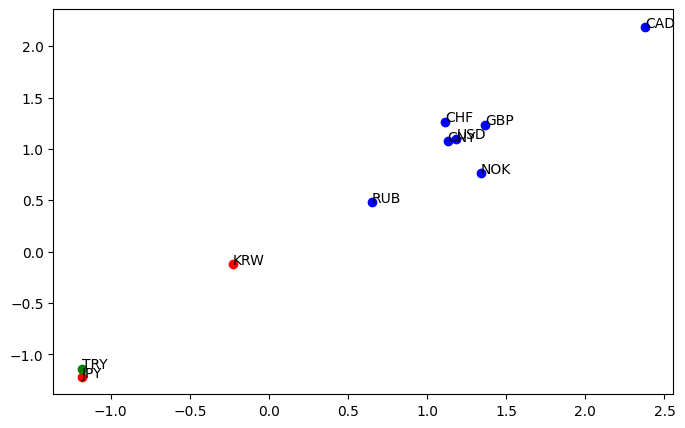

In [536]:
agg = cluster.AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete', compute_distances=True)
labels = agg.fit_predict(data_transposed)
plt.figure(figsize=(8,5))
import matplotlib.colors as colors
cols=['b', 'r', 'g', 'r', 'y', 'g']
for i in [0,1,2,3,4,5]:
    plt.scatter(data_transposed.iloc[labels==i, 0], data_transposed.iloc[labels==i, 1], c=cols[i])
for i, label in enumerate(data_transposed.index):
    plt.annotate(label, (data_transposed.iloc[i,0], data_transposed.iloc[i,1]))

The currencies are plotted at different distances from each other. This will be used to calculate the dendrogram

Creating the linkage matrix:

In [543]:
def create_linkage(agg):
    n_samples = len(agg.labels_)
    counts = np.zeros(agg.children_.shape[0])
    for i, merge in enumerate(agg.children_):
        current_count = 0
        #print (i, merge)
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([agg.children_, agg.distances_,counts]).astype(float)
    return linkage_matrix

matrix=create_linkage(agg)

Now we can create dendrogram:

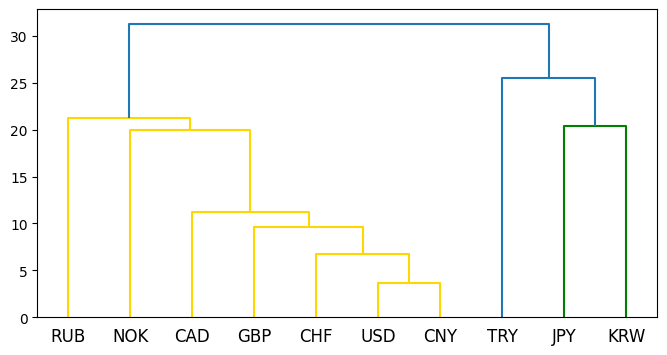

In [538]:
hierarchy.set_link_color_palette(['gold', 'green', 'blue', 'red'])
plt.figure(figsize=(8,4))
dendrogram(
    matrix,
    color_threshold=25,
    orientation='top', 
    labels=data_transposed.index, 
    leaf_rotation=0,
    )
plt.show()

We see 3 clusters of currences.

The first two RUB and NOK seem to have distances slightly longer than other currences in the group. We can try to form 4 clusters to find out

Experiment with 4 initial clusters

In [590]:
agg = cluster.AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete', compute_distances=True)
labels = agg.fit_predict(data_transposed)

Linkage matrix

In [591]:
def create_linkage(agg):
    n_samples = len(agg.labels_)
    counts = np.zeros(agg.children_.shape[0])
    for i, merge in enumerate(agg.children_):
        current_count = 0
        #print (i, merge)
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([agg.children_, agg.distances_,counts]).astype(float)
    return linkage_matrix

matrix=create_linkage(agg)

Dendrogram

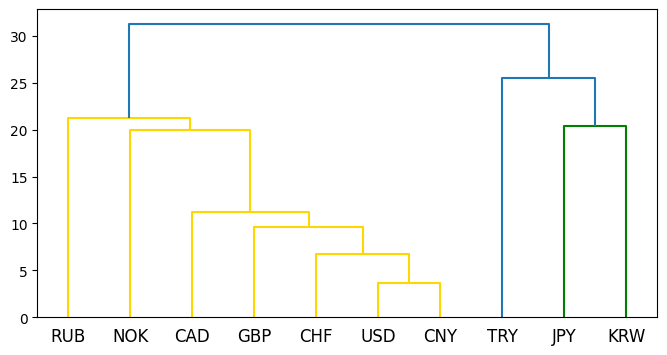

In [592]:
hierarchy.set_link_color_palette(['gold', 'green', 'blue', 'red'])
plt.figure(figsize=(8,4))
dendrogram(
    matrix,
    color_threshold=25,
    orientation='top', 
    labels=data_transposed.index, 
    leaf_rotation=0,
    )
plt.show()

The result the same - 3 clusters. There is no improvement in clustering

Next step - Experiment with 3 clusters and average linkage type

In [566]:
agg = cluster.AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average', compute_distances=True)
labels = agg.fit_predict(data_transposed)

The linkage matrix:

In [567]:
def create_linkage(agg):
    n_samples = len(agg.labels_)
    counts = np.zeros(agg.children_.shape[0])
    for i, merge in enumerate(agg.children_):
        current_count = 0
        #print (i, merge)
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([agg.children_, agg.distances_,counts]).astype(float)
    return linkage_matrix

matrix=create_linkage(agg)

Dendrogram

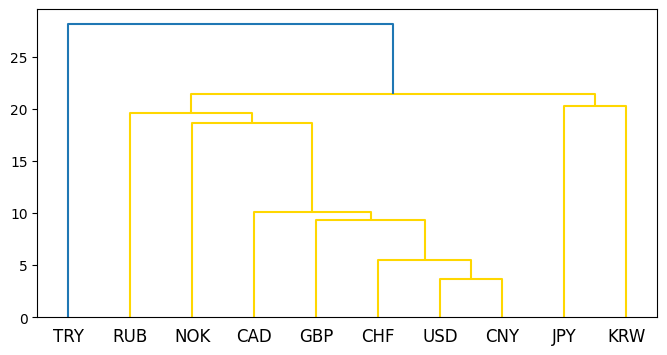

In [568]:
hierarchy.set_link_color_palette(['gold', 'green', 'blue', 'red'])
plt.figure(figsize=(8,4))
dendrogram(
    matrix,
    color_threshold=25,
    orientation='top', 
    labels=data_transposed.index, 
    leaf_rotation=0,
    )
plt.show()

From the experiments we can see that 3 clusters is the sufficient result for hierarchical clustering:
* 1st group: RUB, NOK, CAD, GBP, CHF, USD, CNY
* 2nd group: JPY, KRW
* 3rd group: TRY

Historical volatility is calculated from the past values of an exchange rate. Historical volatility provides a good assessment of possible future changes when the financial markets and economies have not gone through structural changes. 
Exchange rate volatility, like the volatility of any other financial asset, changes in response to information. Currency
traders are sensitive to information that might influence the value of one currency in terms of another. The most
important information is that about the macroeconomic performance of the economies behind the two currencies.
Uncertainty about the future is the most important reason for the change in the
volatility in the currency markets. Central banks can also influence the volatility of their currencies with their announcements
of their intentions to either intervene or otherwise in the markets for their currencies. 

# EM Algorithm

Now it's time to use the EM Algorithm for clustering currencies and check conclusions from the dedrogram.

EM is an iterative algorithm to find the maximum likelihood when there are latent variables

3 clusters were initially selected

In [587]:
model_results = np.array(model_results) #we use 2 main components for clustering
gm=GaussianMixture(n_components=3) #we begin with 3 clusters
cluster_assignments=gm.fit_predict(model_results)
colors=['darkorange', 'darkmagenta', 'dodgerblue']

A function for creating the ellipses in the plot

In [588]:
def create_ellipse(gmm, ax, n, v0, v1, angle, color, alpha, stretch):
    ell = mpl.patches.Ellipse(
        gmm.means_[n, :2], stretch*v0, stretch*v1, 180 + angle, color=color
    )
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(alpha)
    ax.add_artist(ell)


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)

        create_ellipse(gmm, ax, n, v[0], v[1], angle, color, 0.5, 1)
        create_ellipse(gmm, ax, n, v[0], v[1], angle, color, 0.2, 2)
        create_ellipse(gmm, ax, n, v[0], v[1], angle, color, 0.1, 3)
        ax.set_aspect("equal", "datalim")

Plotting the results of EM algorithm

C:\Users\lenovo\AppData\Local\Temp\ipykernel_23712\870935678.py:2: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(


<Figure size 800x800 with 0 Axes>

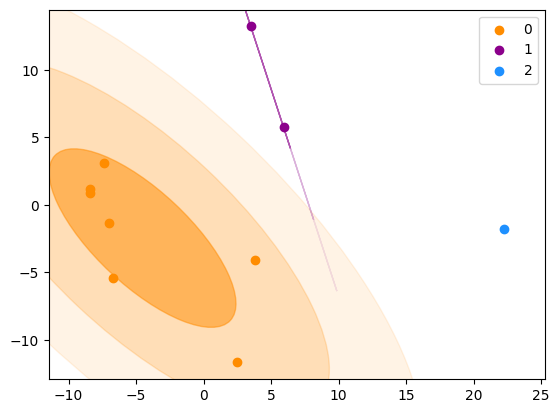

In [589]:
fig=plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()
for i in range(0,len(np.unique(cluster_assignments))):
    data_sub=model_results[cluster_assignments==i, :]
    plt.scatter(data_sub[:,0], data_sub[:,1], c=colors[i], label=i)
make_ellipses(gm, ax)
plt.legend()

Now we can look at the result of EM algorithm clustering with 4 components

In [593]:
gm=GaussianMixture(n_components=4) #the number of components is 4
cluster_assignments=gm.fit_predict(model_results)
colors=['darkorange', 'darkmagenta', 'dodgerblue', 'gold']

In [594]:
def create_ellipse(gmm, ax, n, v0, v1, angle, color, alpha, stretch):
    ell = mpl.patches.Ellipse(
        gmm.means_[n, :2], stretch*v0, stretch*v1, 180 + angle, color=color
    )
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(alpha)
    ax.add_artist(ell)


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)

        create_ellipse(gmm, ax, n, v[0], v[1], angle, color, 0.5, 1)
        create_ellipse(gmm, ax, n, v[0], v[1], angle, color, 0.2, 2)
        create_ellipse(gmm, ax, n, v[0], v[1], angle, color, 0.1, 3)
        ax.set_aspect("equal", "datalim")

Visualization EM algorithm

C:\Users\lenovo\AppData\Local\Temp\ipykernel_23712\870935678.py:2: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(


<Figure size 800x800 with 0 Axes>

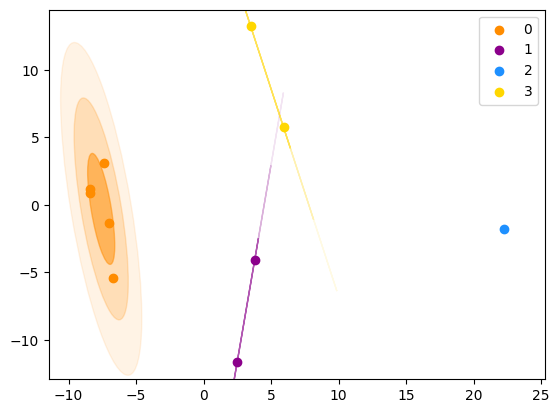

In [595]:
fig=plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()
for i in range(0,len(np.unique(cluster_assignments))):
    data_sub=model_results[cluster_assignments==i, :]
    plt.scatter(data_sub[:,0], data_sub[:,1], c=colors[i], label=i)
make_ellipses(gm, ax)
plt.legend()

4 clusters are good result

### Density Based Clustering (DBSCAN) doesn't work with this dataset

In [596]:
model_results = np.array(model_results)
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=2, min_samples=2, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=10, p=None, n_jobs=3)
dbscan_clusters=dbscan.fit_predict(model_results)
print(np.unique(dbscan_clusters)) # -1 is the marker for noise instances

[-1  0]


No matter wwhat parameters to choose: epsilon (0.1 - 5.0), minimum samples (2-10), forms of metrics(euclidean, manhattan), the result is the same - the method forms the noise (-1) and one cluster (0). It can be concluded that density-based clustering doesn't work with this dataset

Function for plotting results

In [597]:
def plot_clusters(model_results, clusters):
    for cluster in np.unique(clusters):
        if (cluster!=-1):
            data_cluster=model_results[clusters==cluster, :]
            plt.scatter(data_cluster[:,0], data_cluster[:,1], c=colors[cluster])
    data_noise=model_results[clusters==-1, :]
    plt.scatter(data_noise[:,0], data_noise[:,1], c='black')

Visualization DBSCAN

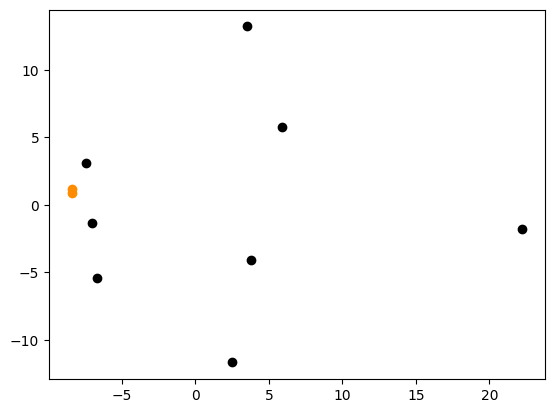

In [598]:
plot_clusters(model_results,dbscan_clusters)

We can see that only two currencies are in the one cluster and other 8 instancies are the noise. It is obviously that this method doesn't work well with such dataset

# Conclusions

We analised a dataset of collection of values of exchange rates of 10 currencies for the 1 year period

Good results were shown under EM algorithm and HAC. As a result of clusterization we can group 10 currencies into 3 clusters due to exchange rates variability:
* 1st group: RUB, NOK, CAD, GBP, CHF, USD, CNY
* 2nd group: JPY, KRW
* 3rd group: TRY

Next steps after this project could be:
* adding new currencies for analysis
* adding new time intervals for analysis
* using of additional country characteristics as variables in the clustering algorithms
All of the above additional steps will help to improve the quality of the clustering and produce a correct final model

## Disclaimer ##
The content of this Notebook is not an investment advice and does not constitute any offer or solicitation to offer or recommendation of any investment product. It is for educational purposes only and does not take into account most of financial information and individual needs, investment objectives and specific financial circumstances. Investment involves risk.